# Embedded ML - Lab 3: Accelerators for ML

Tensor Flow Lite is not only a vehicle to export models to be used in Tensor Flow Lite Micro. It's also an interpreter to run inference on devices that have less resources than servers or standard computers, such as mobile phones, drones, network cameras, etc. In this lab we will use TF Lite to implement an ML application on an embedded platform that features a GPU.

### Learning outcomes


* Explain the differences between a Tensor Flow and a TF Lite environment
* Use the TF Lite API to implement an ML application on an embedded GPU
* Understand the performance differences between TF and TF Lite
* Understand the performance differences between embedded and higher-end GPUs
* Use tools for execution time and memory measurement

### Basic performance measurement

In this lab you'll be required to measure the execution **time** and **memory** consumption of certain code sequences. There are many ways of achieving this and you are encouraged to investigate yourself a bit what options are available and how they differ from each other.

When measuring **execution time**, you should think and decide what is the piece of code you are really interested in measuring, and your conclusions must take that into account. Also notice that the shorter time the code takes, the less accurate can be the measurement because any other thing happening in the system will be a significant noise. Besides using more specialized libraries for accurate time measuring, one common trick you can use is to run a short piece of code many times in a loop, measuring the total loop time and diving by the number of iterations. For this lab you could start with the **time.time()** method of the time Python library.

In [49]:
import time

start = time.time()

# here goes the code you want to measure

end = time.time()
print("Execution time:", end - start, "seconds")

Execution time: 0.0 seconds


With respect to memory consumption, different parts of a program require different amounts of memory. In this lab we are instrested in the maximum amount of memory, or **peak memory**, because it determines an absolute resource requirement that any device that aims to run the code must meet.

For this lab you could start with the **memory_info()** method of psutil Python library.

In [50]:
import psutil, os

process = psutil.Process(os.getpid())
before = process.memory_info().rss

# here goes the code you want to measure

after = process.memory_info().rss
print(f"Memory increased by {(after - before) / 1024 / 1024:.2f} MB")

Memory increased by 0.00 MB


### TensorFlow Lite workflow

We have already seen the TF Lite basic workflow in Lab 2.2. We will now use TF Lite on an embedded platform that includes a GPU device to understand its capabilities and limitations.

Run the following code on the **Jetson Nano board** and on a **workstation GPU** and compare their **latencies** amd **peak memory** usage. The code **trains** and exports a TF Lite model for classifying the Fashion MNIST dataset.

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import json

In [52]:
archivo = "stats.json"

if os.path.exists(archivo):
    with open(archivo, 'r') as f:
        data = json.load(f)
else:
    datos = data = {"exp1": {}}
    
exp = "exp1"
device = "Workstation"  # or "JetsonNano"
gpu = "NO_GPU"


In [53]:
# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Class names for the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           	'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = models.Sequential([
	layers.Flatten(input_shape=(28, 28)),
	layers.Dense(128, activation='relu'),
	layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
          	loss='sparse_categorical_crossentropy',
          	metrics=['accuracy'])
start = time.time()
process = psutil.Process(os.getpid())
before = process.memory_info().rss
model.fit(train_images, train_labels, epochs=2)

end = time.time()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

data[exp]["time_train_TF"] = end - start
data[exp]["mem_train_TF"] = mem
data[exp]["config"] = {
	"device": device,
	"gpu": gpu,
}

print(f"Time: {(end - start):2f}[s], Memory {mem:.2f} MB")
print('\nFinished model training')

C:\Users\Santiago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7832 - loss: 0.6220
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8602 - loss: 0.3813
Time: 16.422712[s], Memory -42.45 MB

Finished model training


In [54]:
start = time.time()
process = psutil.Process(os.getpid())
before = process.memory_info().rss
# test model accuracy
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

end = time.time()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

data[exp]["time_total_infer_TF"] = end - start
data[exp]["time_avg_infer_TF"] = (end - start)/test_images.shape[0]
data[exp]["mem_infer_TF"] = mem
print(f"Time: {(end - start):2f}[s], avg time: {((end-start)/test_images.shape[0]):2f}[s], \
Memory {mem:.2f} MB")

# export model to a keras file
model.save("fmnist.keras")

313/313 - 1s - 3ms/step - accuracy: 0.8641 - loss: 0.3755

Test accuracy: 0.8640999794006348
Time: 1.087660[s], avg time: 0.000109[s], Memory 1.12 MB


In [55]:
# load model from a keras file
from keras.models import load_model

model = load_model("fmnist.keras")

In [56]:
# convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save converted model to a file
import pathlib
tflite_model_file = pathlib.Path('fmnist.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Santiago\AppData\Local\Temp\tmpywb6ott2\assets


INFO:tensorflow:Assets written to: C:\Users\Santiago\AppData\Local\Temp\tmpywb6ott2\assets


Saved artifact at 'C:\Users\Santiago\AppData\Local\Temp\tmpywb6ott2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2836068373264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836068374224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836068383632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836068377488: TensorSpec(shape=(), dtype=tf.resource, name=None)


409036

## Verify Models TensorFlow

Verify that the model files were exported and use them to run **inference**, both on the Jetson Nano and on a **workstation GPU** using **Tensor Flow**. Contrast **latency** and **peak memory** results too.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


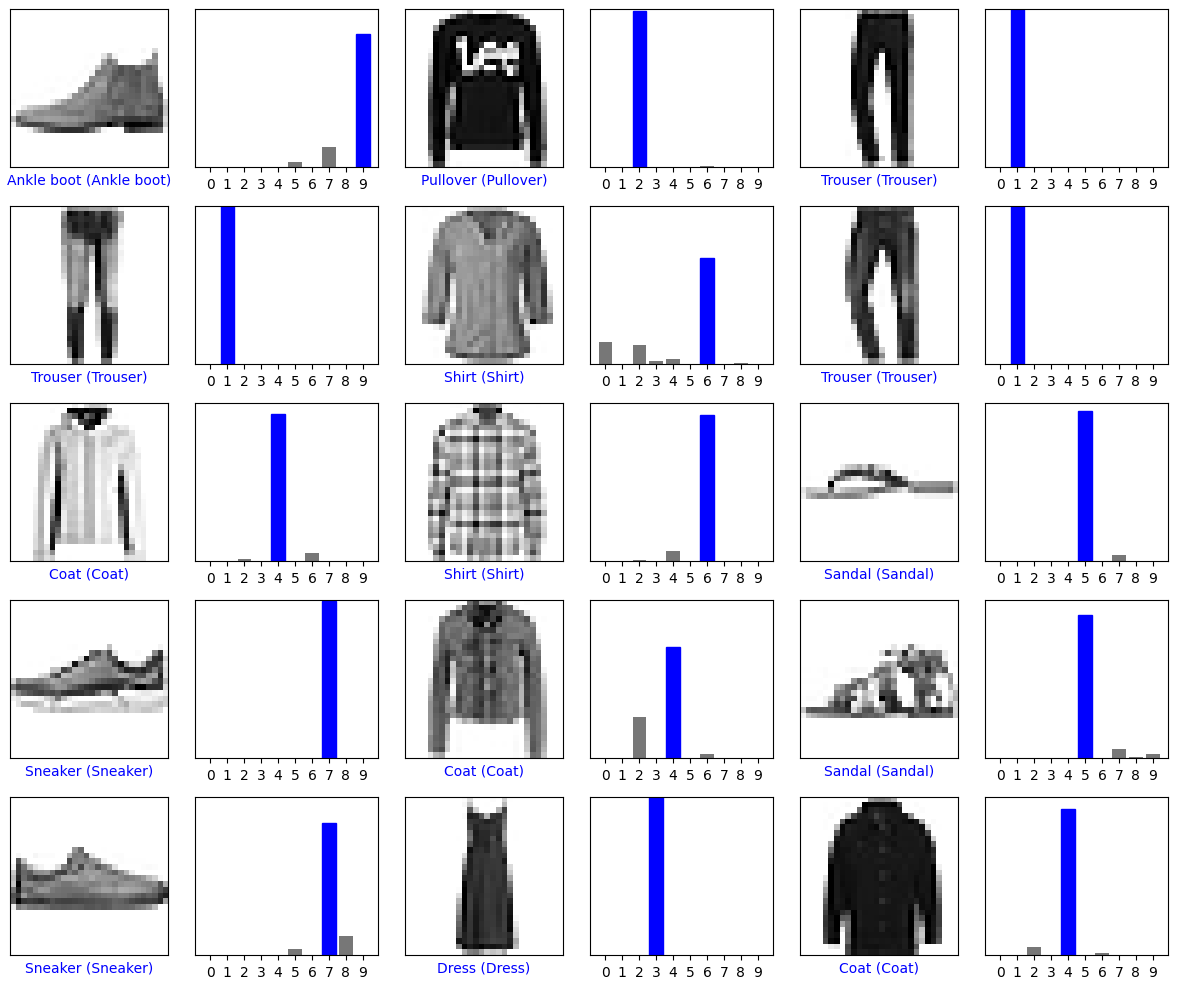

In [57]:
start = time.time()
process = psutil.Process(os.getpid())
before = process.memory_info().rss

predictions = model.predict(test_images)

end = time.time()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

data[exp]["time_total_infer_TF"] = end - start
data[exp]["time_avg_infer_TF"] = (end - start)/test_images.shape[0]
data[exp]["mem_infer_TF"] = mem

# Function to plot the image, its true label, and the predicted label
def plot_image(i, predictions_array, true_label, img):
	true_label, img = true_label[i], img[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])

	plt.imshow(img, cmap=plt.cm.binary)

	predicted_label = np.argmax(predictions_array)
	if predicted_label == true_label:
		color = 'blue'
	else:
		color = 'red'

	plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
	true_label = true_label[i]
	plt.grid(False)
	plt.xticks(range(10))
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#777777")
	plt.ylim([0, 1])
	predicted_label = np.argmax(predictions_array)

	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
	plot_image(i, predictions[i], test_labels, test_images)
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
	plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Inference TF Lite

Finally, run **inference** with **TF Lite** on both platforms and compare with the previous execution's **latency** and **peak memory** usage.

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(_, _), (test_images, test_labels) = fashion_mnist.load_data()

# Preprocess the test images (normalize and reshape)
test_images = test_images.astype(np.float32) / 255.0

# Select an image for inference
input_image = np.expand_dims(test_images[0], axis=0)

tflite_model_file = "fmnist"
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_file+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

start = time.time()
process = psutil.Process(os.getpid())
before = process.memory_info().rss

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

end = time.time()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024
data[exp]["time_infer_TF_Lite"] = end - start
data[exp]["mem_infer_TF_Lite"] = mem


# Print the output
print("Output:", output_data)

# Optionally, you can get the predicted class
predicted_class = np.argmax(output_data)
print("Predicted class:", predicted_class)

[{'name': 'serving_default_input_layer_4:0', 'index': 0, 'shape': array([ 1, 28, 28]), 'shape_signature': array([-1, 28, 28]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 9, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [[3.1381718e-05 9.9687531e-07 1.9701209e-05 1.6941527e-05 4.8371048e-06
  3.0399229e-02 1.4694576e-05 1.2510362e-01 1.9444571e-03 8.4246409e-01]]
Predicted class: 9


In [59]:
data

{'exp1': {'time_train_TF': 16.422711849212646,
  'mem_train_TF': -42.44921875,
  'config': {'device': 'Workstation', 'gpu': 'NO_GPU'},
  'time_total_infer_TF': 0.930185079574585,
  'time_avg_infer_TF': 9.30185079574585e-05,
  'mem_infer_TF': -3.9453125,
  'time_infer_TF_Lite': 0.0,
  'mem_infer_TF_Lite': 0.00390625}}

Consolidate all results in one or more tables or plots and write down your conclusions.

| Metric   | JetsonNano TF | JetsonNano TF Lite | Workstation TF | Workstation TF Lite |
|----------|---------------|---------------------|----------------|----------------------|
| Time     |               |                     |                |                      |
| Memory   |               |                     |                |                      |
| Energy   |               |                     |                |                      |

**Table 1. Measurements in devices *without* GPU**

| Metric   | JetsonNano TF | JetsonNano TF Lite | Workstation TF | Workstation TF Lite |
|----------|---------------|---------------------|----------------|----------------------|
| Time     |               |                     |                |                      |
| Memory   |               |                     |                |                      |
| Energy   |               |                     |                |                      |

**Table 2. Measurements in devices with GPU**

### CNNs on Tensor Flow Lite

Now it's your turn to develop a TF Lite application. This time make sure you train a convolutional model to classify images from a different dataset you choose from Kaggle, Roboflow, Hugging Face or similar, not Mnist, Fashion Mnist nor ImageNet. Now, performance evaluation will focus only on **inference**.

Use the Jetson Board and the workstation to run inference both with Tensor Flow and TF Lite. Measure the **peak memory** and **time** and estimate the **energy** consumed based on the nominal power consumption of each system or chip.

Repeat the experiments without using a GPU and compare the results. Use the following code to disable GPU use in TensorFlow.

In [60]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Disable all GPUs
tf.config.set_visible_devices([], 'GPU')

Again, consolidate all results in one or more tables or plots and write down your conclusions.